In [1]:
# plotting library
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import CategoricalDtype

# ANOVA library
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr

# cohen's d library
import numpy as np
from itertools import combinations

In [20]:
# data loading
ug_beh = pd.read_csv('../data/LEAP_month1_ug_n129_analysis.csv')

sm_beh = pd.read_csv('../data/LEAP_month1_rl_n125_analysis.csv')
# sm_param = pd.read_csv('./data/rl_model_lme_data_context.csv')

# Ploting functions

In [21]:
# data format and visual standard 
def format(df, task, mod=0):
    if task == 'ug' and mod == 0:
        df['offer'] = df['offer'].astype('int32')

        cat_order = CategoricalDtype(['Healthy','Depression','Anhedonia','Both'], ordered=True)
        df['group']= df['group'].astype(cat_order)
        df.sort_values('group')

        cat_order = CategoricalDtype(['Low','Medium','High'], ordered=True)
        df['offer_bin']= df['offer_bin'].astype(cat_order)
        df = df.sort_values('offer_bin')
    elif task == 'sm' and mod == 0:
        cat_order = CategoricalDtype(['Healthy','Depression','Anhedonia','Both'], ordered=True)
        df['group']= df['group'].astype(cat_order)
        df.sort_values('group')

        cat_order = CategoricalDtype(['numberbar_neg','numberbar_mixed','numberbar_pos'], ordered=True)
        df['block_type']= df['block_type'].astype(cat_order)
        df.sort_values('block_type')

    # Map the 'depression' and 'anhedonia' values to 'high' and 'low'
    df['depression_level'] = pd.Categorical(df['depression'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)
    df['anhedonia_level'] = pd.Categorical(df['anhedonia'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)

    return df

In [22]:
# behavior plotting function
def ug_2x2_plot(df, y_var_label_dict, palette):
    """
    Create a 2x2 level plot with 3 panels using Seaborn.

    Parameters:
    - df: DataFrame containing the data.
    - y_var_label_dict: Dictionary where keys are y-variables and values are y-axis labels.
    - palette: Color palette for the plot (default is 'Set2').
    """
    # Create subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # panel labels
    # panel_labels = ['a', 'b', 'c']

    # Plot each panel
    for i, (y_var, y_label) in enumerate(y_var_label_dict.items()):
        sns.stripplot(data=df, x='depression_level', y=y_var, color='grey', jitter=True, alpha=0.5, size=3, ax=ax[i])
        sns.pointplot(data=df, x='depression_level', y=y_var, hue='anhedonia_level',
            ax=ax[i], errorbar=('se', 1), linestyles="none",
            palette=palette, capsize=.3, dodge=True, legend=False if i < 2 else True)  # Legend only on the last plot
        ax[i].set_ylabel(y_label)
        ax[i].set_xlabel('depression level')
        # add panel label
        # ax[i].text(-0.5, 1.1, panel_labels[i], transform=ax[i].transAxes, fontsize=15, fontweight='bold', va='top')

    # Adjust legend
    plt.legend(title='anhedonia level', bbox_to_anchor=(1.35, 0.5), loc='center', borderaxespad=0, frameon=False)
    plt.tight_layout()
    sns.despine()

    return fig, ax

In [23]:
# behavior plotting function
def sm_2x2_plot(df, y_var, y_label, palette, block_types=None):
    # Set default block types if not provided
    if block_types is None:
        block_types = ['numberbar_neg', 'numberbar_mixed', 'numberbar_pos']
    
    block_names = ['punishment', 'mixed', 'reward']

    # Create subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # panel labels
    # panel_labels = ['a', 'b', 'c']
    # panel_labels = ['d', 'e', 'f']

    for i, block_type in enumerate(block_types):
        if i < 2:
            sns.stripplot(data=df[df['block_type'] == block_type], x='depression_level', y=y_var, color='grey', jitter=True, alpha=0.5, size=3, ax=ax[i])
            sns.pointplot(data=df[df['block_type'] == block_type], x='depression_level', y=y_var, hue='anhedonia_level',
                ax=ax[i], errorbar=('se', 1), linestyles="none",
                palette=palette, capsize=0.3, dodge=False, legend=False)

        else:
            sns.stripplot(data=df[df['block_type'] == block_type], x='depression_level', y=y_var, color='grey', jitter=True, alpha=0.5, size=3, ax=ax[i])
            sns.pointplot(
                data=df[df['block_type'] == block_type], x='depression_level', y=y_var, hue='anhedonia_level',
                ax=ax[i], errorbar=('se', 1), linestyles="none",
                palette=palette, capsize=0.3, dodge=False, legend=True)

        # add panel label
        # ax[i].text(-0.1, 1.1, panel_labels[i], transform=ax[i].transAxes, fontsize=15, fontweight='bold', va='top')
        # ax[i].set_title(block_names[i], pad=20)
        ax[i].set_ylabel(y_label)
        ax[i].set_xlabel('depression level')

    plt.legend(title='anhedonia level', bbox_to_anchor=(1.35, 0.5), loc='center', borderaxespad=0, frameon=False)
    plt.tight_layout()
    sns.despine()

    return fig, ax

In [24]:
# parameter plotting function
def param_violin_2x2_plot(df, y_var_label_dict, palette, panel, split=True, cut=1, linewidth=1.5, fill=False):
    """
    Create a 2x2 level plot with n-panel violin plot using Seaborn.

    Parameters:
    - df: DataFrame containing the data.
    - y_var_label_dict: Dictionary where keys are y-variables and values are y-axis labels.
    - palette: Color palette for the plot (default is 'Set2').
    - split: Whether to split the violin plot by hue (default is True).
    - cut: Distance, in units of bandwidth size, to extend the density past extreme datapoints (default is 1).
    - linewidth: Width of the lines that will be drawn to subdivide the violins (default is 1.5).
    - fill: Whether to fill the violin plot (default is False).
    """
    # Create subplots
    fig, ax = plt.subplots(1, panel, figsize=(15, 5))

    # panel labels
    # panel_labels = ['a', 'b', 'c', 'd']

    # Plot each panel
    for i, (y_var, y_label) in enumerate(y_var_label_dict.items()):
        sns.violinplot(data=df, x='depression_level', y=y_var, hue='anhedonia_level',
            ax=ax[i], split=split, cut=cut,
            linewidth=linewidth, fill=fill, palette=palette, legend=False if i < (panel - 1) else True)
        ax[i].set_ylabel(y_label)
        ax[i].set_xlabel('depression level')
        # ax[i].text(-0.5, 1.1, panel_labels[i], transform=ax[i].transAxes, fontsize=15, fontweight='bold', va='top')

    # Adjust legend
    plt.legend(title='anhedonia level', bbox_to_anchor=(1.35, 0.5), loc='center', borderaxespad=0, frameon=False)
    plt.tight_layout()
    sns.despine()

    return fig, ax

In [25]:
# 2-way ANOVA function 
def two_way_anova_effect_size(df, param):
    """
    Perform 2-way ANOVA and calculate effect size (Partial Eta Squared) for a given parameter.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    param (str): The dependent variable (parameter of interest) for the ANOVA.

    Returns:
    anova_table (pandas.DataFrame): The ANOVA table with effect size (Partial Eta Squared).
    """
    # Fit the 2-way ANOVA model
    model = ols(f'{param} ~ C(depression) * C(anhedonia)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Calculate Partial Eta Squared (η²_p)
    anova_table['eta_sq'] = anova_table['sum_sq'] / (anova_table['sum_sq'].sum() + anova_table['sum_sq'].values[-1])

    # Print the parameter and return the ANOVA table
    print(f"2-way ANOVA Results for {param}:")
    return anova_table

In [26]:
# cohen's d function
def compute_cohens_d(df, param, group_col='group'):
    """
    Compute Cohen's d effect size for each pair of groups in the dataframe.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    param (str): The column name of the dependent variable for which to compute Cohen's d.
    group_col (str): The column name of the categorical variable defining the groups.

    Returns:
    None (prints Cohen's d for each pair of groups)
    """
    # Function to compute Cohen's d
    def cohen_d(x, y):
        nx = len(x)
        ny = len(y)
        dof = nx + ny - 2
        pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
        return (np.mean(x) - np.mean(y)) / pooled_std

    # Get unique groups from the specified group column
    groups = df[group_col].unique()

    print(f'Effect size (Cohen\'s d) for {param}:')
    
    # Compute Cohen's d for each pair of groups
    for group1, group2 in combinations(groups, 2):
        data1 = df[df[group_col] == group1][param]
        data2 = df[df[group_col] == group2][param]
        d = cohen_d(data1, data2)
        print(f"Cohen's d between {group1} and {group2}: {d:.4f}")

In [27]:
sns.set(font_scale=1.3, style='white')
sns.set_context('talk')

ug_palette = {
    'low': '#abb9f5',
    "high": '#565d7b'
}
sm_palette = {
    'low': '#f5abb9',
    "high": '#7b565d'
}

# Ultimatum Game Figure

## UG behavior results

In [12]:
ug_beh = format(ug_beh, 'ug')
ug_sub = ug_beh.groupby(['participant', 'depression_level','anhedonia_level']).mean().reset_index()[['participant','depression_level','anhedonia_level','choice_rt', 'log_rt', 'choice_acc', 'rating']].dropna()

y_var_label_dict = {
    'log_rt': 'log reaction time (s)',
    'choice_acc': 'acceptance rate',
    'rating': 'mood rating'
}

C:\Users\fuq01\AppData\Local\Temp\ipykernel_31092\2992657298.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ug_sub = ug_beh.groupby(['participant', 'depression_level','anhedonia_level']).mean().reset_index()[['participant','depression_level','anhedonia_level','choice_rt', 'log_rt', 'choice_acc', 'rating']].dropna()


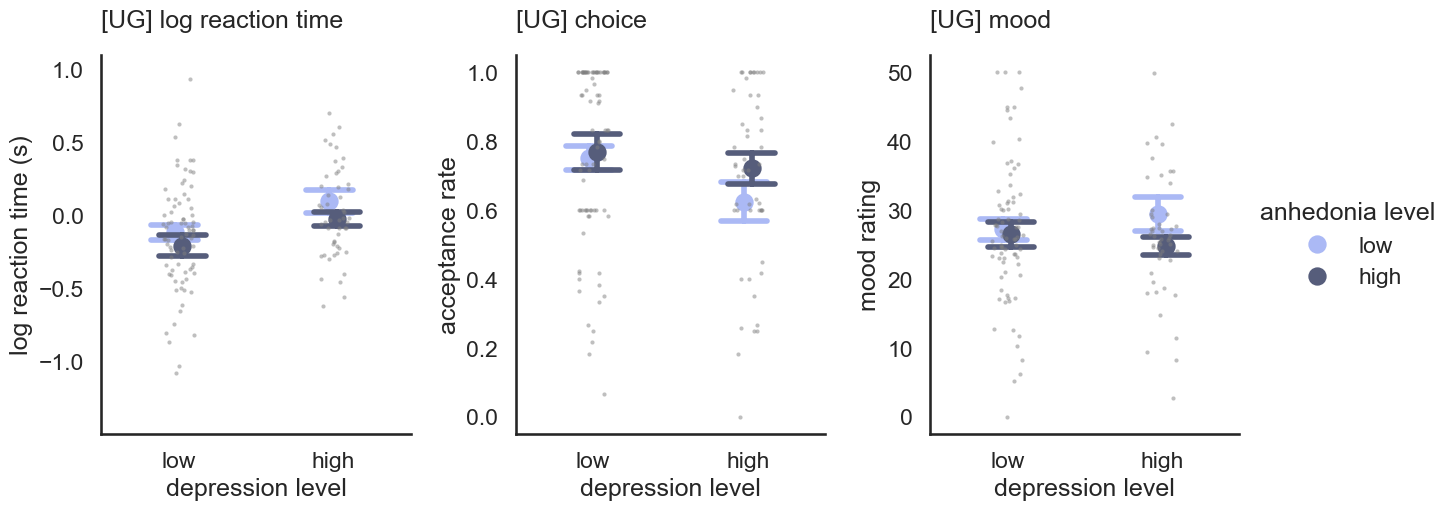

In [16]:
fig, ax = ug_2x2_plot(ug_sub, y_var_label_dict, ug_palette)

# add title
ax[0].set_title('[UG] log reaction time', loc='left', pad=20)
ax[0].set_ylim(-1.5, 1.1)
ax[0].set_yticks([-1.0, -0.5, 0, 0.5, 1])

ax[1].set_title('[UG] choice', loc='left', pad=20)
ax[2].set_title('[UG] mood', loc='left', pad=20)

# save figure
# plt.savefig('./figure/fig2_2.pdf', dpi=300)

# Show the updated plot
plt.show()

## UG model results

In [11]:
# load modeling results
ug_fixf0 = pd.read_csv('../ug_modeling/month1_fit/UG_fit_RWfixf0b_T3_May25.csv')
ug_varf0 = pd.read_csv('../ug_modeling/month1_fit/UG_fit_RWvarf0_T3_May25.csv')

# concate all models together
ug_all = pd.concat([ug_fixf0, ug_varf0], axis=0)

In [12]:
# model labels
model_labels = {
    'RWfixf0b': 'fixed f0',
    'RWvarf0':   'variable f0'
}

# replace the model names
ug_all['model'] = ug_all['model'].replace(model_labels)

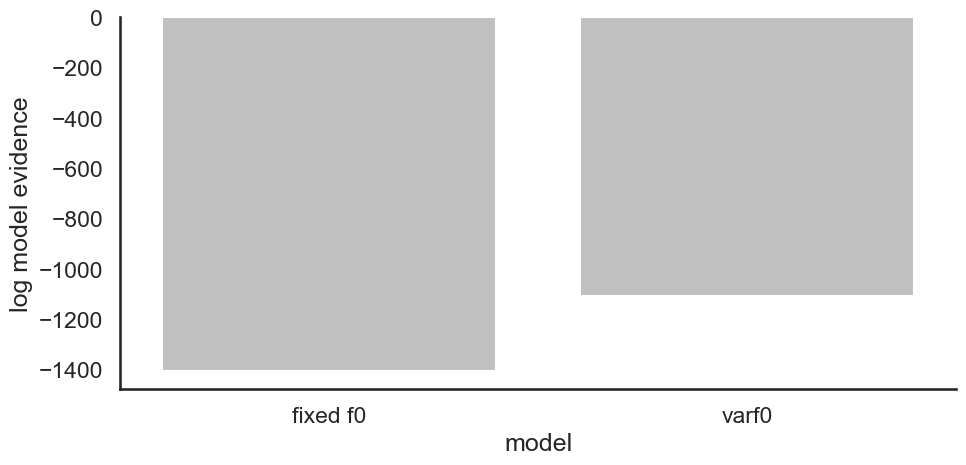

In [13]:
# Get LME per model
lme = ug_all.groupby('model')['LME'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='LME', data=lme, color='silver')
plt.ylabel('log model evidence')
sns.despine()

# Adjust layout and save full figure
plt.tight_layout()
plt.savefig('../figure/T3_modeling_ug/T3_LME2.png', dpi=300)

In [14]:
lme

,model,LME
0,fixed f0,-1408.539212
1,varf0,-1110.013646


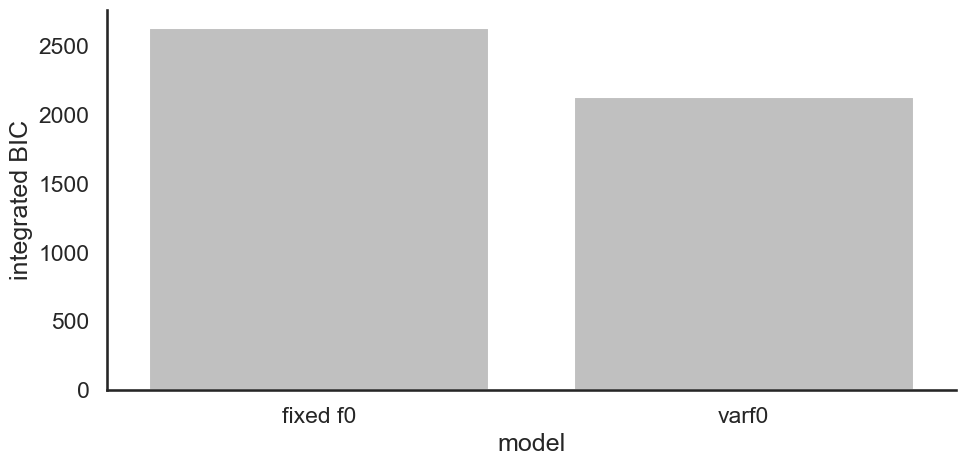

In [15]:
# Get BIC per model
bic = ug_all.groupby('model')['BICint'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='BICint', data=bic, color='silver')
plt.ylabel('integrated BIC')
sns.despine()

# Adjust layout and save full figure
plt.tight_layout()
plt.savefig('../figure/T3_modeling_ug/T3_intBIC2.png', dpi=300)

In [16]:
bic

,model,BICint
0,fixed f0,2631.125968
1,varf0,2129.069352


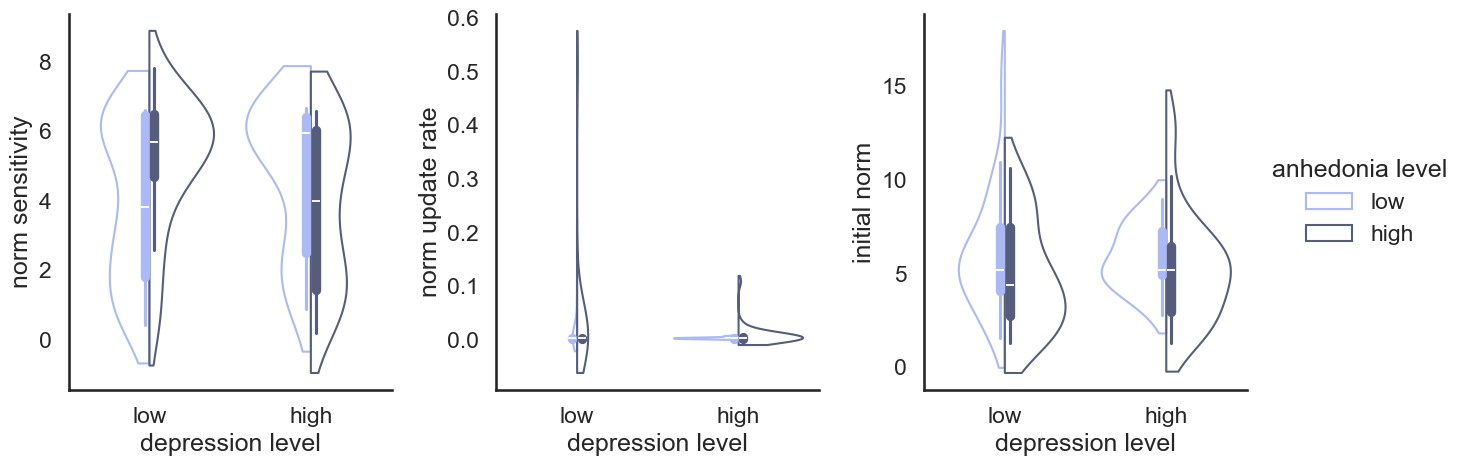

In [17]:
# UG winning model fitted plot
ug_fit_dict = {
    'envy': 'norm sensitivity',
    'lr': 'norm update rate',
    # 'beta': 'inverse temperature',
    'f0': 'initial norm'
}

ug_varf0 = format(ug_varf0, 'ug', mod=1)
fig, ax = param_violin_2x2_plot(df=ug_varf0, y_var_label_dict=ug_fit_dict, palette=ug_palette, panel=3)

# Adjust layout and save full figure
plt.tight_layout()
plt.savefig('../figure/T3_modeling_ug/T3_varf0_win.png', dpi=300)

In [24]:
# perform two way ANONA for envy parameter 
anova_table = two_way_anova_effect_size(ug_FSvarf0, 'envy')
print(anova_table)

2-way ANOVA Results for envy:
                                sum_sq    df         F    PR(>F)        eta_sq
C(depression)                 0.130034   1.0  0.034283  0.853484  1.693129e-04
C(anhedonia)                  0.000038   1.0  0.000010  0.997476  4.966984e-08
C(depression):C(anhedonia)   16.882181   1.0  4.450986  0.037403  2.198178e-02
Residual                    375.497878  99.0       NaN       NaN  4.889244e-01


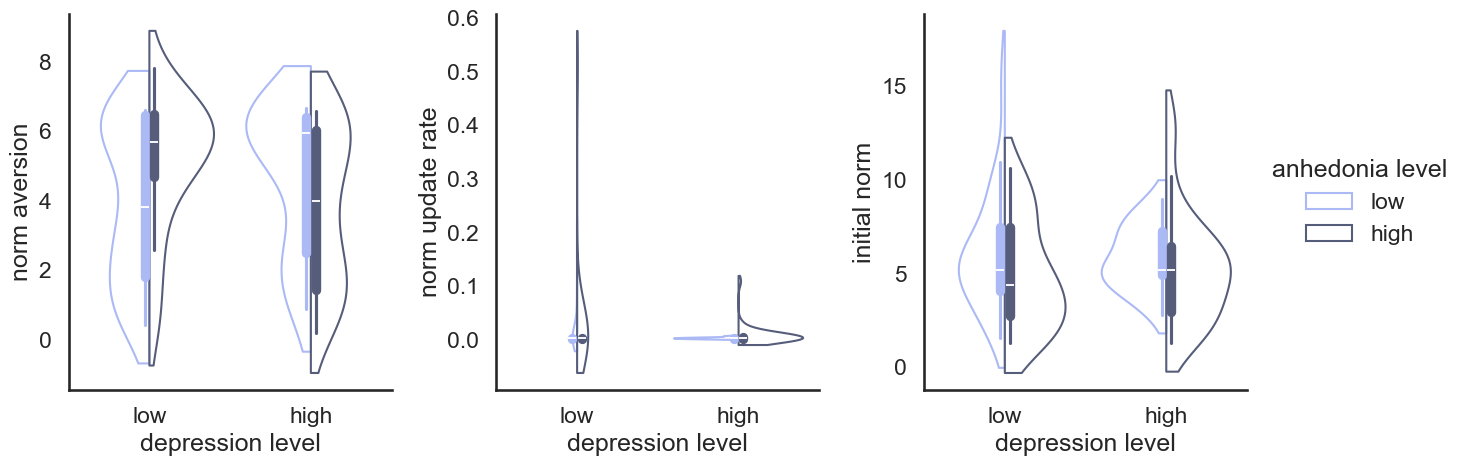

In [26]:
# UG model fitted plot
ug_fit_dict = {
    'envy': 'norm aversion',
    'lr': 'norm update rate',
    # 'beta': 'inverse temperature',
    'f0': 'initial norm'
}
ug_RWvarf0 = format(ug_RWvarf0, 'ug', mod=1)
fig, ax = param_violin_2x2_plot(df=ug_RWvarf0, y_var_label_dict=ug_fit_dict, palette=ug_palette, panel=3)

# Adjust layout and save full figure
plt.tight_layout()
plt.savefig('./figure/T3_modeling_ug/T3_RWvarf0.png', dpi=300)

In [19]:
ug_FSvarf0['participant'].nunique()

103

In [20]:
# all effect size for loop
for param in ug_fit_dict.keys():
    compute_cohens_d(ug_FSvarf0, param)

Effect size (Cohen's d) for envy:
Cohen's d between Anhedonia and Depression: -0.0332
Cohen's d between Anhedonia and Both: 0.4942
Cohen's d between Anhedonia and Healthy: 0.3903
Cohen's d between Depression and Both: 0.4876
Cohen's d between Depression and Healthy: 0.3927
Cohen's d between Both and Healthy: -0.0626
Effect size (Cohen's d) for beta:
Cohen's d between Anhedonia and Depression: 0.0389
Cohen's d between Anhedonia and Both: 0.3148
Cohen's d between Anhedonia and Healthy: 0.3603
Cohen's d between Depression and Both: 0.2854
Cohen's d between Depression and Healthy: 0.3307
Cohen's d between Both and Healthy: 0.0729
Effect size (Cohen's d) for f0:
Cohen's d between Anhedonia and Depression: -0.4407
Cohen's d between Anhedonia and Both: -0.0253
Cohen's d between Anhedonia and Healthy: -0.2426
Cohen's d between Depression and Both: 0.4691
Cohen's d between Depression and Healthy: 0.1968
Cohen's d between Both and Healthy: -0.2361


## UG model regression data

In [27]:
ug_param_df = ug_FSvarf0[['participant', 'envy', 'beta', 'f0']]
ug_param_df.head()

,participant,envy,beta,f0
0,6078163f1e585e4f71e3b879,6.081768,0.605131,1.343125
1,62839ba4a4ace124f3a3889c,8.536790,0.763623,4.988005
2,60ceeec3a0bed4a1e603b8d7,8.579537,0.763549,6.157324
3,55b508f4fdf99b1c26c21c69,5.836108,0.487270,3.862266
4,5825335ac297cc0001df28b2,8.536791,0.763623,4.988005


In [33]:
# load dataframe for psychiatric labels 
baseline_demo = pd.read_csv('../4.online_study_nbs/data/LEAP_n236_demographics.csv')
ug_reg = pd.merge(ug_param_df, baseline_demo, how='left', on='participant')
ug_reg.head(), ug_reg['participant'].nunique()

(                participant      envy      beta        f0  age  sex  gender  \
 0  6078163f1e585e4f71e3b879  6.081768  0.605131  1.343125   61    2       2   
 1  62839ba4a4ace124f3a3889c  8.536790  0.763623  4.988005   47    2       2   
 2  60ceeec3a0bed4a1e603b8d7  8.579537  0.763549  6.157324   32    1       1   
 3  55b508f4fdf99b1c26c21c69  5.836108  0.487270  3.862266   34    2       3   
 4  5825335ac297cc0001df28b2  8.536791  0.763623  4.988005   44    2       2   
 
    edu_level  ladder_us  queer  ... total_prior_diag  md_anx_prior_diag  \
 0          4          4      0  ...                0                  0   
 1          3          3      0  ...                3                  3   
 2          5          7      0  ...                0                  0   
 3          5          1      1  ...                2                  2   
 4          4          4      0  ...                5                  3   
 
   non_md_prior_diag  bdi_total  pvss_total  apathy_score  a

In [34]:
ug_reg.to_csv('../4.online_study_nbs/lme_project/ug_T3_model_lme_data_FSvarf0.csv')

# Reversal Learning Figure

## RL behavior results

In [30]:
sm_beh = format(sm_beh, 'sm')
sm_sub = sm_beh.groupby(['participant', 'depression_level','anhedonia_level','block_type']).mean().reset_index()[['participant','depression_level','anhedonia_level','block_type', 'log_rt', 'rt', 'optimal']].dropna()

C:\Users\fuq01\AppData\Local\Temp\ipykernel_31092\2167114598.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sm_sub = sm_beh.groupby(['participant', 'depression_level','anhedonia_level','block_type']).mean().reset_index()[['participant','depression_level','anhedonia_level','block_type', 'log_rt', 'rt', 'optimal']].dropna()


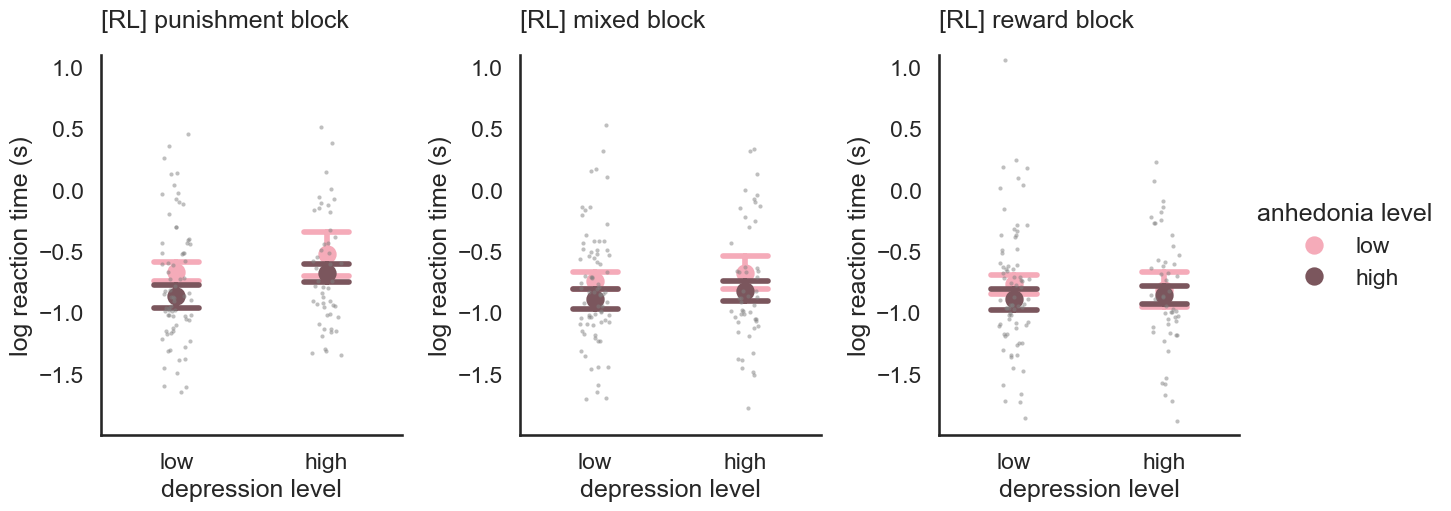

In [31]:
fig, ax = sm_2x2_plot(sm_sub, 'log_rt', 'log reaction time (s)', sm_palette)

# add title
ax[0].set_title('[RL] punishment block', loc='left', pad=20)
ax[0].set_ylim(-2, 1.1)
ax[0].set_yticks([-1.5, -1.0, -0.5, 0, 0.5, 1])

ax[1].set_title('[RL] mixed block', loc='left', pad=20)
ax[1].set_ylim(-2, 1.1)
ax[1].set_yticks([-1.5, -1.0, -0.5, 0, 0.5, 1])

ax[2].set_title('[RL] reward block', loc='left', pad=20)
ax[2].set_ylim(-2, 1.1)
ax[2].set_yticks([-1.5, -1.0, -0.5, 0, 0.5, 1])

# save figure
# plt.savefig('./figure/fig4_1_2.pdf', dpi=300)

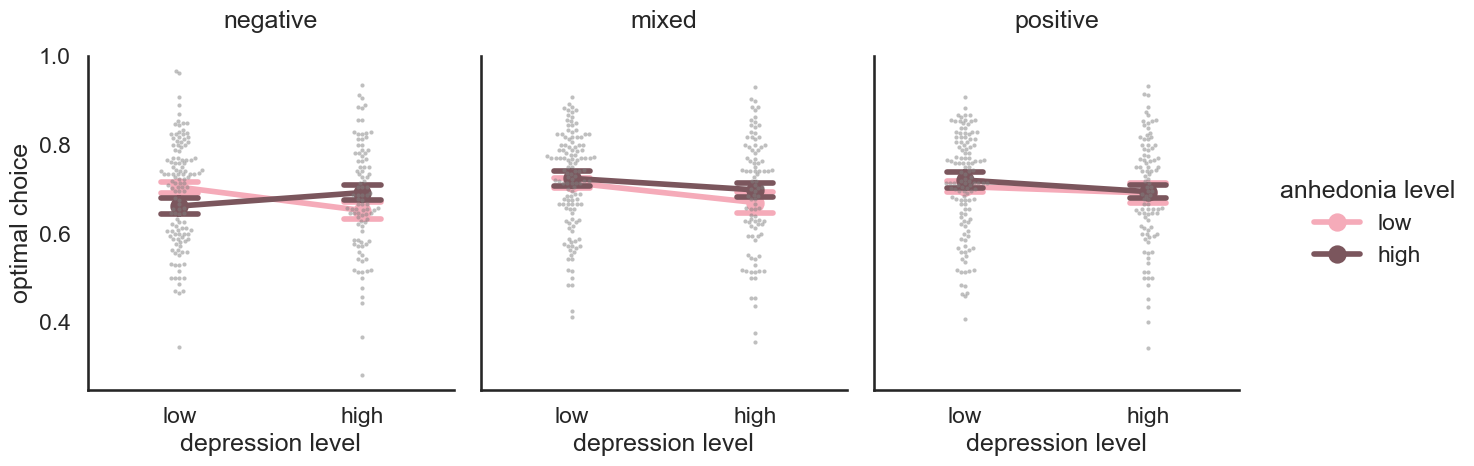

In [29]:
fig, ax = sm_2x2_plot(sm_sub, 'optimal', 'optimal choice', sm_palette)
# # Add a floating significance line to a specific subplot (e.g., subplot 0)
# ax[0].plot([0.1, 0.9], [0.98, 0.98], transform=ax[0].transAxes, color='black', linestyle='-', linewidth=2)
# # Add '*' to indicate significance at the top center above the line
# ax[0].text(0.5, 0.95, '*', transform=ax[0].transAxes, color='black', fontsize=25, verticalalignment='bottom', horizontalalignment='center', fontweight='bold')

# save figure
plt.savefig('./figure/fig4_2_2.pdf', dpi=300)

## RL model results

In [37]:
# load modeling results
rl_basic = pd.read_csv('../RL-EM/3_month1_fit/RL_fit_RW_basic_T3_May25.csv')
rl_valence = pd.read_csv('../RL-EM/3_month1_fit/RL_fit_RW_valence_T3_May25.csv')
rl_outcome = pd.read_csv('../RL-EM/3_month1_fit/RL_fit_RW_outcome_T3_May25.csv')
rl_context = pd.read_csv('../RL-EM/3_month1_fit/RL_fit_RW_context_T3_May25.csv')

# concate all models together
rl_all = pd.concat([rl_basic, rl_valence, rl_outcome, rl_context], axis=0)

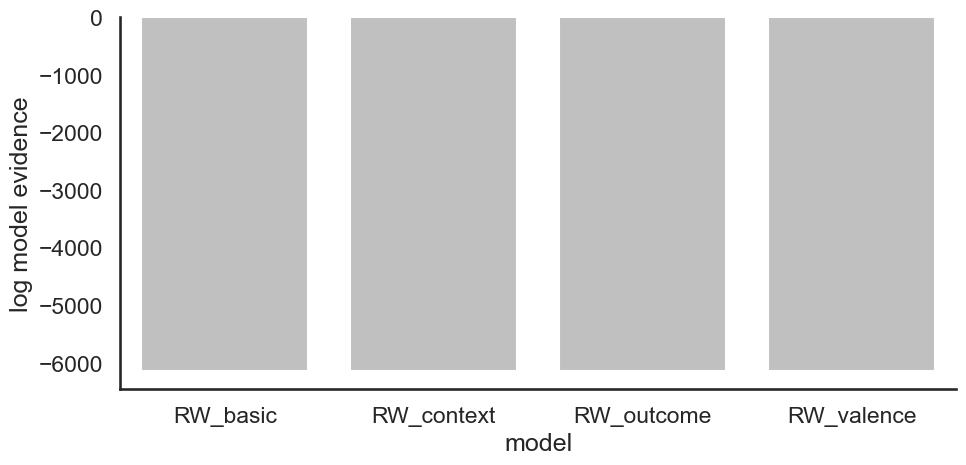

In [38]:
# Get LME per model
lme = rl_all.groupby('model')['LME'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='LME', data=lme, color='silver')
plt.ylabel('log model evidence')
sns.despine()

# Adjust layout and save full figure
plt.tight_layout()
plt.savefig('./figure/T3_modeling_rl/T3_LME.png', dpi=300)

In [47]:
lme['LME'].min()

-6150.50393788284

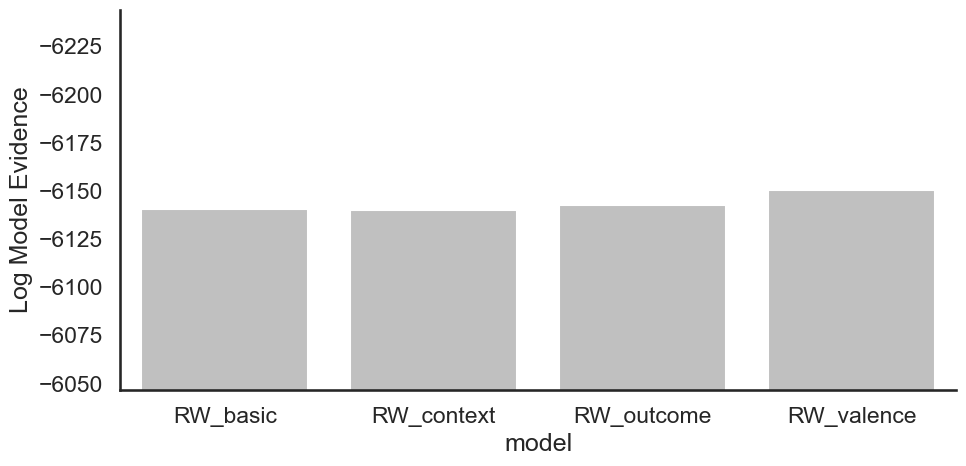

In [49]:
# Determine min and max LME, then zoom in with a buffer
y_min = lme['LME'].min() + 100
y_max = lme['LME'].max() - 100
buffer = (y_max - y_min) * 0.2  # 20% buffer for spacing

plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='LME', data=lme, color='silver')
plt.ylim(y_min - buffer * 0.1, y_max + buffer * 0.1)  # Add some padding

plt.ylabel('Log Model Evidence')
sns.despine()
plt.tight_layout()
# plt.savefig('./figure/T3_modeling_rl/T3_LME.png', dpi=300)


In [50]:
lme

,model,LME
0,RW_basic,-6140.845212
1,RW_context,-6140.073587
2,RW_outcome,-6142.885391
3,RW_valence,-6150.503938


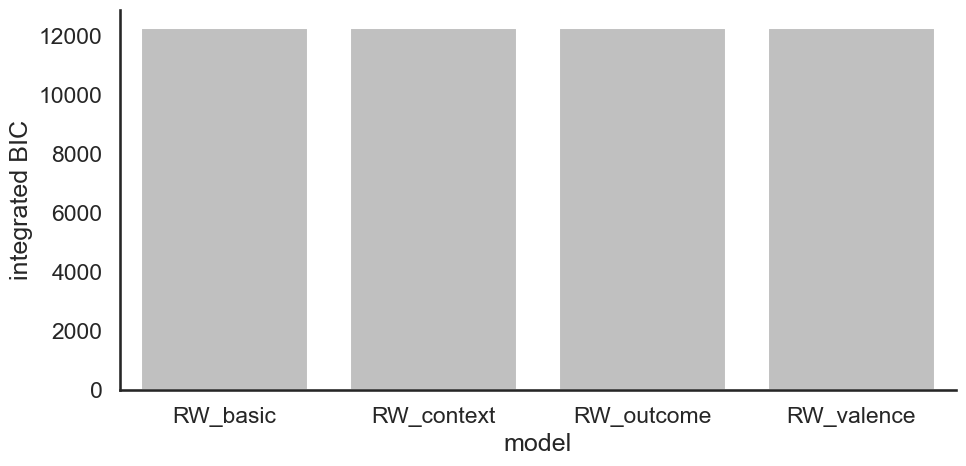

In [51]:
# Get BIC per model
bic = rl_all.groupby('model')['BICint'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='BICint', data=bic, color='silver')
plt.ylabel('integrated BIC')
sns.despine()

# Adjust layout and save full figure
plt.tight_layout()
plt.savefig('./figure/T3_modeling_rl/T3_intBIC.png', dpi=300)

In [52]:
bic

,model,BICint
0,RW_basic,12271.153969
1,RW_context,12265.548380
2,RW_outcome,12269.129851
3,RW_valence,12268.473893


In [53]:
rl_context

,alpha_opt,alpha_pes,alpha_mix,beta,participant,bic,model,BICint,LME,depression,anhedonia,group,depression_level,anhedonia_level
0,0.998678,0.998778,0.866603,1.098693,54e32a60fdf99b3eae9de85b,116.861220,RW_context,12265.54838,-6140.073587,1,1,Both,high,high
1,0.998671,0.998775,0.929607,1.098693,5590a34cfdf99b729d4f69dc,109.426440,RW_context,12265.54838,-6140.073587,1,0,Depression,high,low
2,0.998676,0.998781,0.943028,1.098693,5596a991fdf99b2d1e834690,110.251275,RW_context,12265.54838,-6140.073587,0,0,Healthy,low,low
3,0.998672,0.998784,0.939924,1.098693,55b237e6fdf99b19ea79d2f7,104.567750,RW_context,12265.54838,-6140.073587,1,1,Both,high,high
4,0.998672,0.998780,0.893254,1.098693,55b508f4fdf99b1c26c21c69,109.810795,RW_context,12265.54838,-6140.073587,1,1,Both,high,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.998679,0.998783,0.952030,1.098693,636168a962acef1f1f1cc4ce,98.186387,RW_context,12265.54838,-6140.073587,0,1,Anhedonia,low,high
127,0.998672,0.998774,0.926453,1.098693,63a0d718bbed03d92665039e,111.907456,RW_context,12265.54838,-6140.073587,0,0,Healthy,low,low
128,0.998673,0.998777,0.866979,1.098693,63ae31ff5c725a41082afc56,119.448295,RW_context,12265.54838,-6140.073587,1,1,Both,high,high
129,0.998685,0.998775,0.944093,1.098693,63c34086cb929e7c9b844a67,124.682094,RW_context,12265.54838,-6140.073587,0,1,Anhedonia,low,high


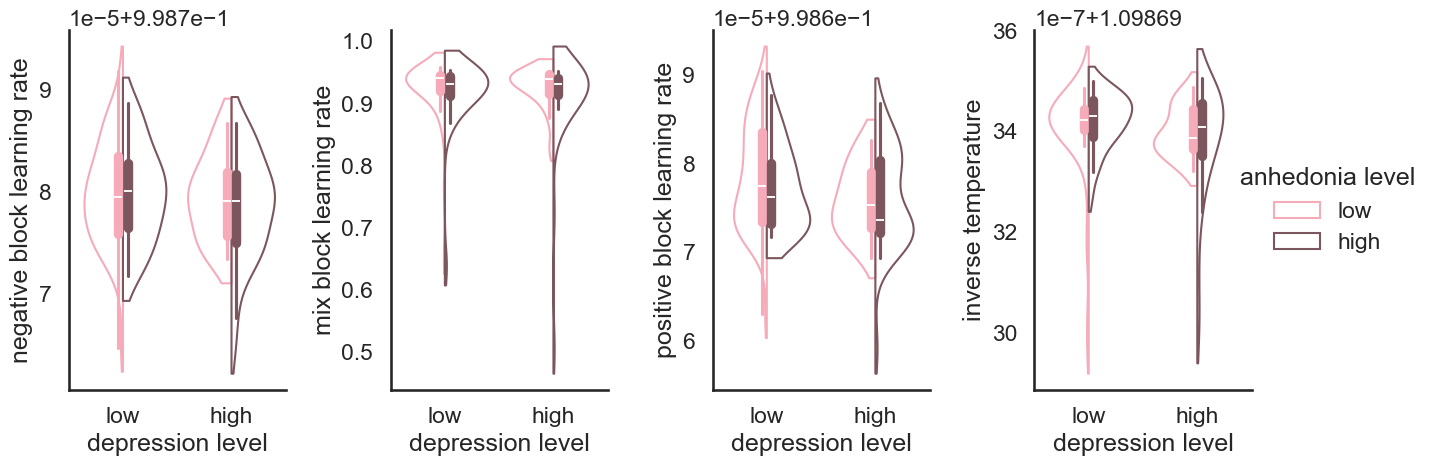

In [56]:
sm_fit_dict = {
    'alpha_pes': 'negative block learning rate',
    'alpha_mix': 'mix block learning rate',
    'alpha_opt': 'positive block learning rate',
    'beta': 'inverse temperature'
}

sm_param = format(rl_context, 'sm', mod=1)

# sm_param['alpha_pos_round'] = sm_param['alpha_pos'].round(5)
# sns.violinplot(data=df, x='group', y='value_rounded')

# Call the function
param_violin_2x2_plot(df=sm_param, y_var_label_dict=sm_fit_dict, palette=sm_palette, panel=4)

# save figure
plt.savefig('./figure/T3_modeling_rl/T3_context_win.png', dpi=300)

In [57]:
rl_context['participant'].nunique()

131

In [58]:
# all effect size for loop
for param in sm_fit_dict.keys():
    compute_cohens_d(sm_param, param)

Effect size (Cohen's d) for alpha_pes:
Cohen's d between Both and Depression: -0.2121
Cohen's d between Both and Healthy: -0.2711
Cohen's d between Both and Anhedonia: -0.3008
Cohen's d between Depression and Healthy: -0.0740
Cohen's d between Depression and Anhedonia: -0.1034
Cohen's d between Healthy and Anhedonia: -0.0210
Effect size (Cohen's d) for alpha_mix:
Cohen's d between Both and Depression: -0.2500
Cohen's d between Both and Healthy: -0.2336
Cohen's d between Both and Anhedonia: -0.1277
Cohen's d between Depression and Healthy: 0.0491
Cohen's d between Depression and Anhedonia: 0.1592
Cohen's d between Healthy and Anhedonia: 0.1093
Effect size (Cohen's d) for alpha_opt:
Cohen's d between Both and Depression: 0.0182
Cohen's d between Both and Healthy: -0.4220
Cohen's d between Both and Anhedonia: -0.2101
Cohen's d between Depression and Healthy: -0.4609
Cohen's d between Depression and Anhedonia: -0.2711
Cohen's d between Healthy and Anhedonia: 0.2460
Effect size (Cohen's d) 

## RL model regression data

maybe no need to prep additional, just use the valence file for regression (parameter and psych level)

In [59]:
rl_context

,alpha_opt,alpha_pes,alpha_mix,beta,participant,bic,model,BICint,LME,depression,anhedonia,group,depression_level,anhedonia_level
0,0.998678,0.998778,0.866603,1.098693,54e32a60fdf99b3eae9de85b,116.861220,RW_context,12265.54838,-6140.073587,1,1,Both,high,high
1,0.998671,0.998775,0.929607,1.098693,5590a34cfdf99b729d4f69dc,109.426440,RW_context,12265.54838,-6140.073587,1,0,Depression,high,low
2,0.998676,0.998781,0.943028,1.098693,5596a991fdf99b2d1e834690,110.251275,RW_context,12265.54838,-6140.073587,0,0,Healthy,low,low
3,0.998672,0.998784,0.939924,1.098693,55b237e6fdf99b19ea79d2f7,104.567750,RW_context,12265.54838,-6140.073587,1,1,Both,high,high
4,0.998672,0.998780,0.893254,1.098693,55b508f4fdf99b1c26c21c69,109.810795,RW_context,12265.54838,-6140.073587,1,1,Both,high,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.998679,0.998783,0.952030,1.098693,636168a962acef1f1f1cc4ce,98.186387,RW_context,12265.54838,-6140.073587,0,1,Anhedonia,low,high
127,0.998672,0.998774,0.926453,1.098693,63a0d718bbed03d92665039e,111.907456,RW_context,12265.54838,-6140.073587,0,0,Healthy,low,low
128,0.998673,0.998777,0.866979,1.098693,63ae31ff5c725a41082afc56,119.448295,RW_context,12265.54838,-6140.073587,1,1,Both,high,high
129,0.998685,0.998775,0.944093,1.098693,63c34086cb929e7c9b844a67,124.682094,RW_context,12265.54838,-6140.073587,0,1,Anhedonia,low,high


In [60]:
rl_param_df = rl_context[['participant','alpha_opt', 'alpha_pes', 'alpha_mix', 'beta']]
rl_param_df.head()

,participant,alpha_opt,alpha_pes,alpha_mix,beta
0,54e32a60fdf99b3eae9de85b,0.998678,0.998778,0.866603,1.098693
1,5590a34cfdf99b729d4f69dc,0.998671,0.998775,0.929607,1.098693
2,5596a991fdf99b2d1e834690,0.998676,0.998781,0.943028,1.098693
3,55b237e6fdf99b19ea79d2f7,0.998672,0.998784,0.939924,1.098693
4,55b508f4fdf99b1c26c21c69,0.998672,0.998780,0.893254,1.098693


In [64]:
# load dataframe for psychiatric labels 
rl_reg = pd.merge(rl_param_df, baseline_demo, how='left', on='participant')
rl_reg.head(), rl_reg['participant'].nunique()

(                participant  alpha_opt  alpha_pes  alpha_mix      beta  age  \
 0  54e32a60fdf99b3eae9de85b   0.998678   0.998778   0.866603  1.098693   38   
 1  5590a34cfdf99b729d4f69dc   0.998671   0.998775   0.929607  1.098693   57   
 2  5596a991fdf99b2d1e834690   0.998676   0.998781   0.943028  1.098693   31   
 3  55b237e6fdf99b19ea79d2f7   0.998672   0.998784   0.939924  1.098693   54   
 4  55b508f4fdf99b1c26c21c69   0.998672   0.998780   0.893254  1.098693   34   
 
    sex  gender  edu_level  ladder_us  ...  total_prior_diag md_anx_prior_diag  \
 0    2       2          5          2  ...                 1                 1   
 1    2       2          5          5  ...                 0                 0   
 2    1       1          3          5  ...                 0                 0   
 3    2       2          5          4  ...                 4                 3   
 4    2       3          5          1  ...                 2                 2   
 
    non_md_prior_diag bd

In [65]:
rl_reg.to_csv('../4.online_study_nbs/lme_project/rl_T3_model_lme_data_context.csv')